# SETUP

## Constants

In [1]:
# Generating skip-grams

CONTEXT_WINDOW_SIZE = 8

# Hyperparameters
EPOCHS = 200
LR = 0.001
BATCH_SIZE = 32
EMB_DIM = 50

## Import

In [2]:
import os
from shared.constants import *
from shared.models import SavedModelSkipGram, HyperparametersSkipGram

import re
from nltk import word_tokenize, sent_tokenize

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import lightning as L
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# DATA

In [3]:
with open(TXT_FILE) as f:
    text = f.read()
    text = re.sub(CHAPTER_LINE, '', text, flags=re.MULTILINE | re.IGNORECASE)

## Tokenized Corpus

In [4]:
sentences = sent_tokenize(text)
tokenized_corpus = []

for sentence in sentences:
    tokens = []
    for word in word_tokenize(sentence):
        word = word.strip(PUNCTUATION)
        if word:
            tokens.append(word)
    tokens.append('<EOS>')
    tokenized_corpus.append(tokens)

print(tokenized_corpus[:3])

[['It', 'is', 'a', 'truth', 'universally', 'acknowledged', 'that', 'a', 'single', 'man', 'in', 'possession', 'of', 'a', 'good', 'fortune', 'must', 'be', 'in', 'want', 'of', 'a', 'wife', '<EOS>'], ['However', 'little', 'known', 'the', 'feelings', 'or', 'views', 'of', 'such', 'a', 'man', 'may', 'be', 'on', 'his', 'first', 'entering', 'a', 'neighbourhood', 'this', 'truth', 'is', 'so', 'well', 'fixed', 'in', 'the', 'minds', 'of', 'the', 'surrounding', 'families', 'that', 'he', 'is', 'considered', 'as', 'the', 'rightful', 'property', 'of', 'some', 'one', 'or', 'other', 'of', 'their', 'daughters', '<EOS>'], ['My', 'dear', 'Mr', 'Bennet', 'said', 'his', 'lady', 'to', 'him', 'one', 'day', 'have', 'you', 'heard', 'that', 'Netherfield', 'Park', 'is', 'let', 'at', 'last', 'Mr', 'Bennet', 'replied', 'that', 'he', 'had', 'not', '<EOS>']]


## Indexed Corpus

In [5]:
# Build vocabulary
WORD2IDX = {word: idx for idx, word in enumerate(set(sum(tokenized_corpus, [])))}
IDX2WORD = {idx: word for word, idx in WORD2IDX.items()}
VOCAB_SIZE = len(WORD2IDX)
# Convert tokenized corpus to indexed corpus
indexed_corpus = [[WORD2IDX[word] for word in sentence] for sentence in tokenized_corpus]

print(indexed_corpus[0])
print(len(indexed_corpus))
print(VOCAB_SIZE)

[1459, 2787, 3073, 6462, 3526, 5804, 1513, 3073, 1760, 1842, 4039, 679, 3584, 3073, 1374, 3707, 4887, 6636, 4039, 414, 3584, 3073, 6015, 5771]
4595
6702


## Skip-Gram Pairs

In [6]:
def generate_skipgrams(indexed_corpus, window_size=CONTEXT_WINDOW_SIZE): 
    data = []
    for sentence in indexed_corpus:
        for i, target in enumerate(sentence):
            window = range(max(0, i-window_size), min(len(sentence), i+window_size+1))
            context = [sentence[j] for j in window if j!=i]
            for ctx in context:
                data.append((target, ctx)) # pair every word with each word in the context
    return data

skipgram_pairs = generate_skipgrams(indexed_corpus)[:100]
print(skipgram_pairs[0])
print(len(skipgram_pairs))

(1459, 2787)
100


## Train Data

In [7]:
X_train = torch.LongTensor([pair[0] for pair in skipgram_pairs])  # target words
y_train = torch.LongTensor([pair[1] for pair in skipgram_pairs])  # context words
# nn.Embedding and nn.CrossEntropyLoss require torch.int64 (LongTensor) inputs for indexing and categorical targets.

dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# MODEL

## From Scratch

In [8]:

# class SkipGramModelFromScratch(L.LightningModule):

#     def __init__(self):
#         super().__init__()
#         L.seed_everything(seed=42)
#         self.input_to_hidden = nn.Linear(in_features=len(dataset), out_features=EMB_DIM, bias=False)
#         self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)
#         self.loss = nn.CrossEntropyLoss()

#     def forward(self, input):
#         hidden = self.input_to_hidden(input)
#         # Then we pass "hidden" to the weights we created with nn.Linear() between the hidden layer and the output.
#         output_values = self.hidden_to_output(hidden)
#         return(output_values)


#     def configure_optimizers(self):
#         return Adam(self.parameters(), lr=LR)


#     def training_step(self, batch, batch_idx):
#         input_i, label_i = batch
#         output_i = self.forward(input_i)
#         loss = self.loss(output_i, label_i)
        
#         self.log("train_loss", loss)

#         return loss

## nn.Embedding

In [9]:
# %%capture
# sys.exit("Manual execution required")

MODEL_NAME = f'skipgram_context{CONTEXT_WINDOW_SIZE}_emb{EMB_DIM}_e{EPOCHS}_lr{LR}'
HYPERPARAMETERS = HyperparametersSkipGram(EPOCHS, LR, BATCH_SIZE, EMB_DIM, VOCAB_SIZE)

class SkipGramModelEmbedding(L.LightningModule):

    def __init__(self, vocab_size, emb_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.linear = nn.Linear(emb_dim, vocab_size)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, context_word):
        embedding = self.embeddings(context_word)
        output = self.linear(embedding)
        return output
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=LR)

    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = self.loss(output_i, label_i)

        self.log("train_loss", loss)
        
        return loss
    
    def on_train_end(self):
        """Save the model after training is complete."""
        saved_model = SavedModelSkipGram(
            model_state_dict=self.state_dict(),
            model_hyperparameters=HYPERPARAMETERS
        )
        saved_model.save_model(MODEL_NAME)

if os.path.exists(os.path.join('models', f'{MODEL_NAME}.')):
    raise FileExistsError(f"Model already exists, please choose a different model name.pth")

modelEmbedding = SkipGramModelEmbedding(VOCAB_SIZE, EMB_DIM)
trainer = L.Trainer(max_epochs=EPOCHS, logger=TensorBoardLogger(f"models/logs/", name=MODEL_NAME))
trainer.fit(modelEmbedding, train_dataloaders=dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | embeddings | Embedding        | 335 K  | train
1 | linear     | Linear           | 341 K  | train
2 | loss       | CrossEntropyLoss | 0      | train
--------------------------------------------------------
676 K     Trainable params
0         Non-trainable params
676 K     Total params
2.708     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/home/asdf/Desktop/nlp-basics/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_

Epoch 199: 100%|██████████| 25/25 [00:00<00:00, 53.31it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 25/25 [00:00<00:00, 49.00it/s, v_num=0]
Model saved to models/skipgram_context8_emb50_e200_lr0.001.pth


# DEMO

In [10]:
# Load model

checkpoint = torch.load(f"models/{MODEL_NAME}.pth", weights_only=False)

hyperparameters: HyperparametersSkipGram = checkpoint.model_hyperparameters
model = SkipGramModelEmbedding(hyperparameters.vocab_size, hyperparameters.emb_dim)
model.load_state_dict(checkpoint.model_state_dict)

<All keys matched successfully>

In [11]:
def visualize_words_embedding(model):
  
  words = [
    'Elizabeth', 'Darcy', 'Bingley', 'Lydia', 'Jane', 'Collins', 'Pemberley', 
    'Meryton', 'Lady', 'Wickham', 'marriage', 'love', 'prejudice', 'fortune', 
    'accomplished', 'pride', 'sense', 'character', 'family', 'society',
    'husband', 'wife', 'man', 'woman', 'summer', 'spring', 'winter'
  ]
  
  indices = [WORD2IDX[word] for word in words]
  embeddings = model.embeddings.weight.data[indices]

  tsne = TSNE(n_components=2, perplexity=20, random_state=42) # 2d t-SNE
  embeddings_2d = tsne.fit_transform(embeddings)

  colors = sns.husl_palette(n_colors = len(words))
  plt.figure(figsize=(10, 10))
  for i, word in enumerate(words):
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],c=colors)
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]))
  
  plt.show();

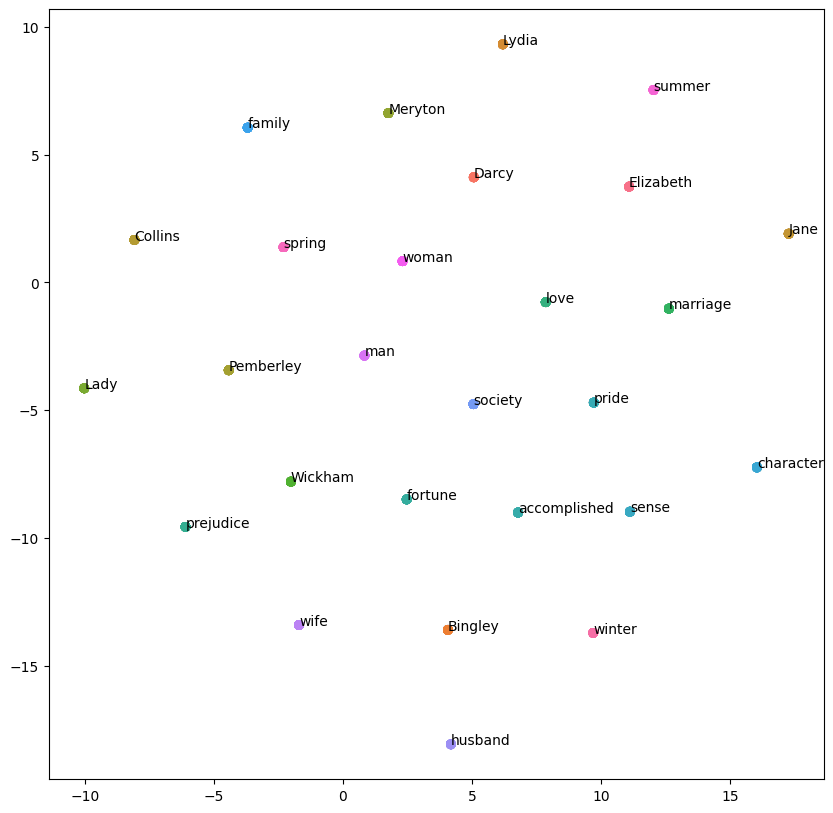

In [12]:
visualize_words_embedding(model)